In [1]:
from matplotlib import rcParams
from warnings import filterwarnings
filterwarnings("ignore")
rcParams["font.size"] = "12"

## Load Data

Download data from gdrive. Original data can be founded [here](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification) (kaggle competition)

In [2]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd
import pandas as pd
from tqdm import tqdm

In [3]:
# donwload from gdrive
gdd.download_file_from_google_drive(file_id='1cjIH-BVLLAi_0qfx2E7DtJjl6G4opQla',
                                    dest_path='./data/data.csv')

In [4]:
# read file
df = pd.read_csv('./data/data.csv')[['comment_text', 'toxic']]
df.shape

(223549, 2)

In [5]:
# display data
df.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
# target distribution
df['toxic'].value_counts()

0    202165
1     21384
Name: toxic, dtype: int64

## Preprocessing

Preprocessing include: lowercase, tokenization, punctuation, stopwords, len(words) from 3 to 9, lemmatization

In [7]:
import numpy as np
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from string import punctuation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maksi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# stopwords & punctuation
stopwords = nltk.corpus.stopwords.words('english')
punctuation = punctuation.replace("!", "")

In [10]:
%%time
# preprocessing
def remove_punctuations(text):
    for punct in punctuation:
        text = text.replace(punct, '')
    return text

# lowercase + \n to " "
df['comment_text'] = df['comment_text'].str.lower().str.replace("\n", " ")
# tokenize
df['comment_text'] = df['comment_text'].apply(nltk.word_tokenize)
# punctuation
df['comment_text'] = df['comment_text'].apply(lambda x: " ".join(x)).apply(remove_punctuations).str.split()
# stopwords
df['comment_text'] = df['comment_text'].apply(lambda x: [i for i in x if i not in stopwords])
 # len(word) > 2 && len(word) < 2
df['comment_text'] = df['comment_text'].apply(lambda x: [i for i in x if len(i) > 2 or len(i) < 10])
# lemmatization
df['comment_text'] = df['comment_text'].apply(lambda x: [nltk.stem.WordNetLemmatizer().lemmatize(i) for i in x]) 

Wall time: 2min 58s


In [11]:
# remove empty texts
not_empty_indexes = df[['comment_text']][df['comment_text'].apply(lambda x: len(x)) != 0].index
df = df.loc[not_empty_indexes]
df.shape

(223496, 2)

In [12]:
# display data after preprocessing
df.head()

,comment_text,toxic
0,"[explanation, edits, made, username, hardcore,...",0
1,"[daww, !, match, background, colour, seemingly...",0
2,"[hey, man, really, trying, edit, war, guy, con...",0
3,"[ca, nt, make, real, suggestion, improvement, ...",0
4,"[sir, hero, chance, remember, page]",0


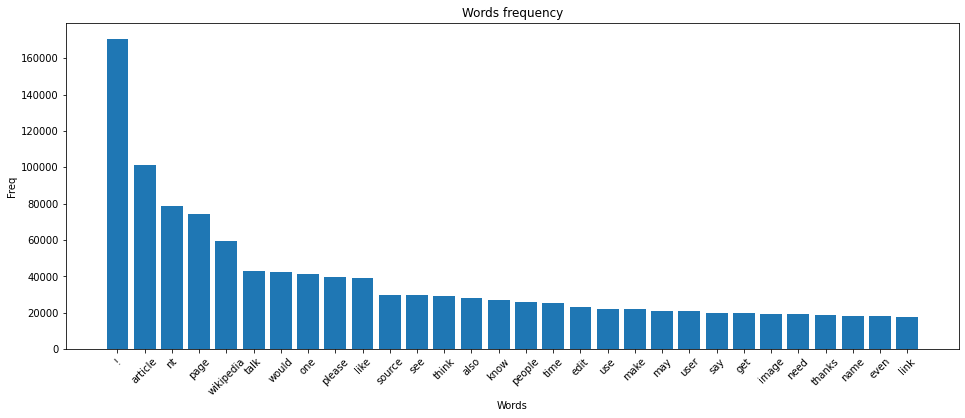

In [13]:
# Words Frequency visualizaion
wordfreq = nltk.FreqDist([j for i in df['comment_text'].tolist() for j in i])
wordfreq = {k: v for k, v in sorted(dict(wordfreq).items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(16, 6))
plt.bar(list(wordfreq.keys())[:30], list(wordfreq.values())[:30])
plt.title('Words frequency')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel('Freq')
plt.show()

In [14]:
# ! sign by class (check does it make sense) => yes, that make sense to left '!' in text
toxic_1 = df.loc[df['toxic']==1, 'comment_text'].apply(lambda x: "!" in x).sum() / df.loc[df['toxic']==1].size
toxic_0 = df.loc[df['toxic']==0, 'comment_text'].apply(lambda x: "!" in x).sum() / df.loc[df['toxic']==0].size
print(f"Toxic: {round(toxic_1, 3)}, Not Toxic: {round(toxic_0, 3)}")

Toxic: 0.129, Not Toxic: 0.066


In [15]:
# split
X_train, X_test, y_train, y_test = train_test_split(df[['comment_text']], df['toxic'], test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
X_train.shape, X_val.shape, X_test.shape

((178796, 1), (22350, 1), (22350, 1))

## Classical ML

Classical ML approaches include: 1) Model by WordsFrequences; 2) Logistic Regression on tf-idf; 3) Random Forest on tf-idf.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from umap import UMAP
import seaborn as sns
from collections import Counter

### Model by WordFreq

Calculate how often word occurs in each class normalized on class probability

In [17]:
# indexes
toxic_indexes = y_train[y_train == 1].index
not_toxic_indexes = y_train[y_train == 0].index
# sentences
sentences = X_train['comment_text'].to_list()
sentences_toxic = X_train.loc[toxic_indexes]['comment_text'].to_list()
sentences_not_toxic = X_train.loc[not_toxic_indexes]['comment_text'].to_list()
assert len(sentences) == (len(sentences_toxic) + len(sentences_not_toxic)), "Total number of sentences do not equal to sum of toxic ant not toxic sentences"
# words
words = [w for sent in sentences for w in sent]
words_toxic = [w for sent in sentences_toxic for w in sent]
words_not_toxic = [w for sent in sentences_not_toxic for w in sent]

In [18]:
# calculate probas: add 1 to each word for toxic and not toxic because we need fill nans by 1 (something like Laplace smoothing)
class_freq = y_train.value_counts(normalize=True).to_dict()
# count words
df_words = pd.DataFrame(dict(Counter(words)), index=['word']).T
df_toxic_words = (pd.DataFrame(dict(Counter(words_toxic)), index=['word_toxic']).T)
df_not_toxic_words = (pd.DataFrame(dict(Counter(words_not_toxic)), index=['word_not_toxic']).T)
# concat
freq_df = pd.concat([df_words, df_toxic_words, df_not_toxic_words], axis=1)
assert all(freq_df['word'] == (freq_df['word_toxic'].fillna(0) + freq_df['word_not_toxic'].fillna(0))), "Numer of words are not equal"
# fill nans
freq_df.fillna(1e-8, inplace=True)
# normalize
freq_df['word_prob'] = freq_df['word'] / freq_df['word'].sum()
freq_df['word_toxic_normalized'] = (freq_df['word_toxic'] / class_freq[1])
freq_df['word_not_toxic_normalized'] = (freq_df['word_not_toxic'] / class_freq[0])
# probs calculation
freq_df['toxic_prob'] = freq_df['word_toxic_normalized'] / (freq_df['word'])
freq_df['not_toxic_prob'] = freq_df['word_not_toxic_normalized'] / (freq_df['word'])
freq_df.round(3).head()

,word,word_toxic,word_not_toxic,word_prob,word_toxic_normalized,word_not_toxic_normalized,toxic_prob,not_toxic_prob
explanation,2295,40.0,2255.0,0.000,416.677,2494.463,0.182,1.087
revdeleted,5,0.0,5.0,0.000,0.000,5.531,0.000,1.106
comment,12552,586.0,11966.0,0.002,6104.315,13236.692,0.486,1.055
badtempered,5,0.0,5.0,0.000,0.000,5.531,0.000,1.106
response,2484,98.0,2386.0,0.000,1020.858,2639.374,0.411,1.063


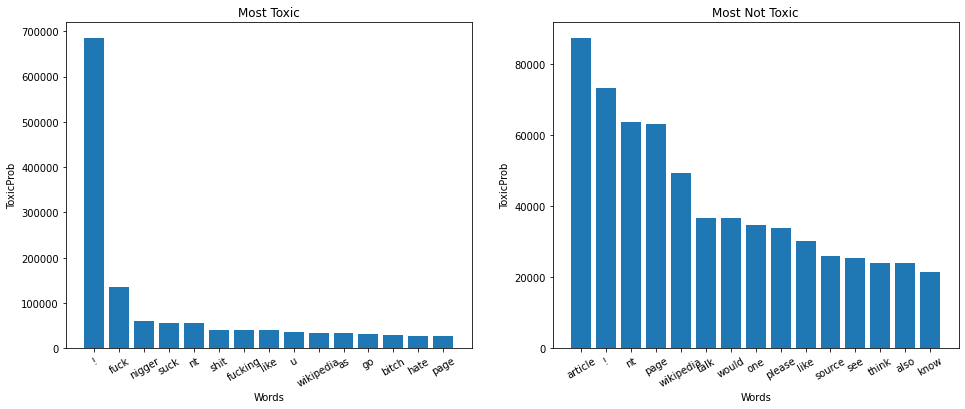

In [19]:
# viz
most_toxic = freq_df.sort_values("word_toxic_normalized", ascending=False)[:15]
most_not_toxic = freq_df.sort_values("word_not_toxic_normalized", ascending=False)[:15]

fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].bar(most_toxic.index, most_toxic['word_toxic_normalized'])
ax[0].tick_params(axis='x', rotation=30)
ax[0].set_title("Most Toxic")
ax[0].set_xlabel("Words")
ax[0].set_ylabel("ToxicProb")
ax[1].bar(most_not_toxic.index, most_not_toxic['word_not_toxic_normalized'])
ax[1].tick_params(axis='x', rotation=30)
ax[1].set_title("Most Not Toxic")
ax[1].set_xlabel("Words")
ax[1].set_ylabel("ToxicProb")
plt.show()

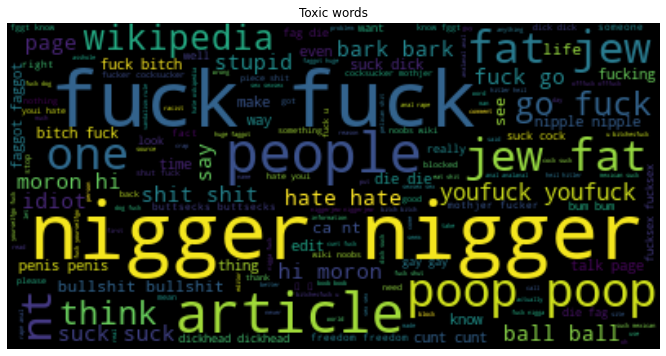

In [20]:
# WordCloud Toxic
wordcloud = WordCloud().generate(" ".join(words_toxic))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Toxic words")
plt.axis("off")
plt.show()

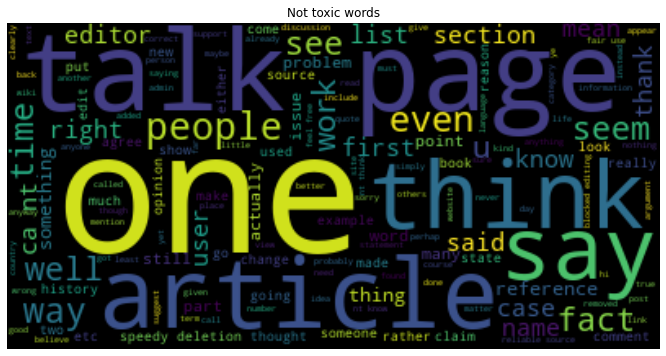

In [21]:
# WordCloud NotToxic
wordcloud = WordCloud().generate(" ".join(words_not_toxic))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Not toxic words")
plt.axis("off")
plt.show()

In [22]:
# calculate probas: sum(words) - len(words), because 
w2toxic_prob = freq_df['toxic_prob'].to_dict()
w2not_toxic_prob = freq_df['not_toxic_prob'].to_dict()
train_pred = X_train['comment_text'].apply(lambda x: sum([w2toxic_prob[i] for i in x]) / (sum([w2not_toxic_prob[i] for i in x]) + 1e-8)) > 1
test_pred = X_test['comment_text'].apply(lambda x: sum([w2toxic_prob[i] for i in x if i in w2toxic_prob]) / (sum([w2not_toxic_prob[i] for i in x if i in w2not_toxic_prob]) + 1e-8)) > 1
train_score = roc_auc_score(y_train, train_pred)
test_score = roc_auc_score(y_test, test_pred)
print(f"TrainScore: {round(train_score, 3)}, TestScore: {round(test_score, 3)}")

TrainScore: 0.921, TestScore: 0.886


### Logistic regression on tf-idf

Simple Logistic Regression with tf-idf

In [23]:
# tfidf
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['comment_text'].apply(" ".join))
X_test_tfidf = vectorizer.transform(X_test['comment_text'].apply(" ".join))
X_val_tfidf = vectorizer.transform(X_val['comment_text'].apply(" ".join))

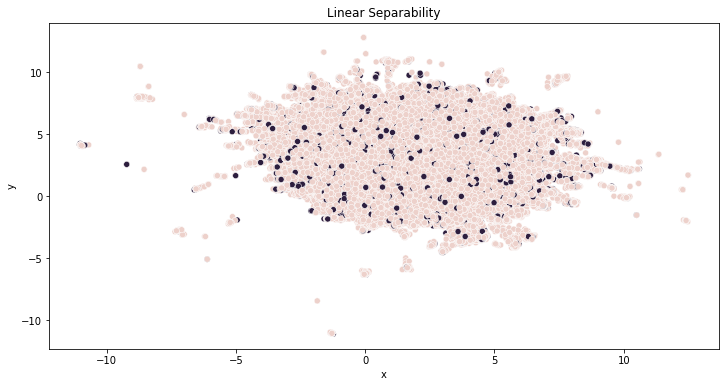

Wall time: 14min 19s


In [24]:
%%time
# tfidf viz => there are no linear separability (after umap)
embedding = UMAP(n_neighbors=30, min_dist=0.5, random_state=42, metric='cosine').fit_transform(X_train_tfidf)
embedding = pd.DataFrame(embedding, columns=['x', 'y'])

plt.figure(figsize=(12,6))
sns.scatterplot(data=embedding, x='x', y='y', hue=df['toxic'], legend=False)
plt.title("Linear Separability")
plt.show()

In [25]:
# grid search
best_score = -np.inf
best_penalty = None
class_weight = X_train.size / (2 * np.bincount(y_train)) # Size / (num_classes * [size_class_0, size_class_1])
class_weight = {0:class_weight[0], 1:class_weight[1]} # class_weight to dict

for C in tqdm(np.arange(0.1, 3, 0.1)):
  model = LogisticRegression(C=C, class_weight=class_weight, max_iter=300)
  model.fit(X_train_tfidf, y_train)
  score = roc_auc_score(y_val, model.predict_proba(X_val_tfidf)[:, 1])
  if score > best_score:
    best_score = score
    best_penalty = C

print(f"\nBest Score: {round(best_score, 2)}, Best Penalty: {best_penalty}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [05:37<00:00, 11.65s/it]


Best Score: 0.97, Best Penalty: 1.2000000000000002


In [26]:
# model&scores
model = LogisticRegression(C=best_penalty, class_weight=class_weight, max_iter=300)
model.fit(X_train_tfidf, y_train)

train_score = roc_auc_score(y_train, model.predict_proba(X_train_tfidf)[:, 1])
test_score = roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:, 1])
print(f"TrainScore: {round(train_score, 3)}, TestScore: {round(test_score, 3)}")

TrainScore: 0.989, TestScore: 0.965


### RandomForest

Random Forest with optuna

In [27]:
from sklearn.ensemble import RandomForestClassifier
import optuna

In [28]:
class_weight = X_train.size / (2 * np.bincount(y_train))
class_weight = {0:class_weight[0], 1:class_weight[1]}
    
def objective(trial):
    # params
    n_estimators = int(trial.suggest_loguniform('n_estimators', 50, 200))
    max_depth = int(trial.suggest_loguniform('max_depth', 2, 32))
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight, n_jobs=-1,
                                   random_state=42)
    model.fit(X_train_tfidf, y_train)
    score = roc_auc_score(y_val, model.predict_proba(X_val_tfidf)[:, 1])
    
    return score

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100,)

[I 2021-10-13 09:37:58,909] A new study created in memory with name: no-name-36886050-e192-4e57-93ca-a46a772bc7d9
[I 2021-10-13 09:38:02,271] Trial 0 finished with value: 0.8690300140336237 and parameters: {'n_estimators': 75.97760924507945, 'max_depth': 18.776290336245232}. Best is trial 0 with value: 0.8690300140336237.
[I 2021-10-13 09:38:04,625] Trial 1 finished with value: 0.86967554170397 and parameters: {'n_estimators': 133.29715851908554, 'max_depth': 8.278316419397429}. Best is trial 1 with value: 0.86967554170397.
[I 2021-10-13 09:38:09,310] Trial 2 finished with value: 0.875089050793731 and parameters: {'n_estimators': 174.4829210840654, 'max_depth': 13.863699751173625}. Best is trial 2 with value: 0.875089050793731.
[I 2021-10-13 09:38:10,723] Trial 3 finished with value: 0.8361919214961178 and parameters: {'n_estimators': 95.19027399452622, 'max_depth': 5.119617222475974}. Best is trial 2 with value: 0.875089050793731.
[I 2021-10-13 09:38:13,454] Trial 4 finished with valu

[I 2021-10-13 09:41:49,886] Trial 36 finished with value: 0.814787590276072 and parameters: {'n_estimators': 139.76854025547982, 'max_depth': 3.133150783406888}. Best is trial 23 with value: 0.8806196671412873.
[I 2021-10-13 09:41:57,691] Trial 37 finished with value: 0.8793302002851805 and parameters: {'n_estimators': 98.18027530894413, 'max_depth': 26.704444055806885}. Best is trial 23 with value: 0.8806196671412873.
[I 2021-10-13 09:42:01,149] Trial 38 finished with value: 0.8717831476905022 and parameters: {'n_estimators': 124.58709491856447, 'max_depth': 13.30766590628955}. Best is trial 23 with value: 0.8806196671412873.
[I 2021-10-13 09:42:04,488] Trial 39 finished with value: 0.8705337987662738 and parameters: {'n_estimators': 191.25379603785584, 'max_depth': 8.296093117500455}. Best is trial 23 with value: 0.8806196671412873.
[I 2021-10-13 09:42:13,748] Trial 40 finished with value: 0.8776676250678265 and parameters: {'n_estimators': 157.34147307355005, 'max_depth': 22.2606746

[I 2021-10-13 09:47:54,892] Trial 73 finished with value: 0.8817605932964419 and parameters: {'n_estimators': 170.98184637552137, 'max_depth': 25.748134099177598}. Best is trial 70 with value: 0.8828958496051549.
[I 2021-10-13 09:48:07,882] Trial 74 finished with value: 0.8816357987008329 and parameters: {'n_estimators': 172.22639414283205, 'max_depth': 26.223665679247215}. Best is trial 70 with value: 0.8828958496051549.
[I 2021-10-13 09:48:15,008] Trial 75 finished with value: 0.8765585961469486 and parameters: {'n_estimators': 170.2887255117312, 'max_depth': 18.796983071531393}. Best is trial 70 with value: 0.8828958496051549.
[I 2021-10-13 09:48:29,000] Trial 76 finished with value: 0.8824696603502259 and parameters: {'n_estimators': 185.72515013309294, 'max_depth': 26.61595233629052}. Best is trial 70 with value: 0.8828958496051549.
[I 2021-10-13 09:48:49,031] Trial 77 finished with value: 0.8802824330231708 and parameters: {'n_estimators': 193.45084100984448, 'max_depth': 31.4993

In [29]:
# score
model = RandomForestClassifier(n_estimators=int(study.best_params['n_estimators']), max_depth=int(study.best_params['max_depth']),
                               class_weight=class_weight, n_jobs=-1, random_state=42)
model.fit(X_train_tfidf, y_train)

train_score = roc_auc_score(y_train, model.predict_proba(X_train_tfidf)[:, 1])
test_score = roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:, 1])
print(f"TrainScore: {round(train_score, 3)}, TestScore: {round(test_score, 3)}")

TrainScore: 0.936, TestScore: 0.887


## NN

Linear and LSTM models, architectures below. Main idea: lets combine embeddings for glove and fasttext

In [30]:
import gensim.downloader as api
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.tensorboard import SummaryWriter
import shutil

In [31]:
%%time
# load models
glove = api.load("glove-wiki-gigaword-200")

Wall time: 48.7 s


In [32]:
%%time
# load models
fasttext = api.load("fasttext-wiki-news-subwords-300")

Wall time: 2min 55s


In [33]:
%%time
# copy for preprocessing
df_glove = df.copy()
df_fasttext = df.copy()
# convert word to vector
df_glove['comment_text'] = df_glove['comment_text'].apply(lambda x: [word for word in x if word in glove.key_to_index])
df_fasttext['comment_text'] = df_fasttext['comment_text'].apply(lambda x: [word for word in x if word in fasttext.key_to_index])
# padding
seq_len = 65
# Glove
df_glove['comment_text'] = df_glove['comment_text'].apply(lambda x: [x, min(seq_len, len(x))])
df_glove['comment_text'] = df_glove['comment_text'].apply(lambda x: [np.pad(x[0][:seq_len], (0, max(0, seq_len - len(x[0]))), constant_values=(0, 0)), x[1]])
# FastText
df_fasttext['comment_text'] = df_fasttext['comment_text'].apply(lambda x: [x, min(seq_len, len(x))])
df_fasttext['comment_text'] = df_fasttext['comment_text'].apply(lambda x: [np.pad(x[0][:seq_len], (0, max(0, seq_len - len(x[0]))), constant_values=(0, 0)), x[1]])

Wall time: 22.9 s


In [34]:
# get vocab
vocab_glove = set([word for doc in df_glove['comment_text'].apply(lambda x: x[0]).values for word in doc])
vocab_fasttext = set([word for doc in df_fasttext['comment_text'].apply(lambda x: x[0]).values for word in doc])

# word2idx & idx2word
word2idx_glove = {j:i for i, j in enumerate(vocab_glove)}
idx2word_glove = {i:j for i, j in enumerate(vocab_glove)}
word2idx_fasttext = {j:i for i, j in enumerate(vocab_fasttext)}
idx2word_fasttext = {i:j for i, j in enumerate(vocab_fasttext)}

In [35]:
# convert word to indexes
df_glove['comment_text'] = df_glove['comment_text'].apply(lambda x: [[word2idx_glove[word] for word in x[0]], x[1]])
df_fasttext['comment_text'] = df_fasttext['comment_text'].apply(lambda x: [[word2idx_fasttext[word] for word in x[0]], x[1]])

In [36]:
# split glove
X_train_glove = df_glove.loc[X_train.index, ['comment_text']]
X_test_glove = df_glove.loc[X_test.index, ['comment_text']]
X_val_glove = df_glove.loc[X_val.index, ['comment_text']]
print(X_train_glove.shape, X_test_glove.shape, X_val_glove.shape)

# split fasttext
X_train_fasttext = df_fasttext.loc[X_train.index, ['comment_text']]
X_test_fasttext = df_fasttext.loc[X_test.index, ['comment_text']]
X_val_fasttext = df_fasttext.loc[X_val.index, ['comment_text']]
print(X_train_fasttext.shape, X_test_fasttext.shape, X_val_fasttext.shape)

# get labels
y_train_nn = df_glove.loc[y_train.index, 'toxic']
y_test_nn = df_glove.loc[y_test.index, 'toxic']
y_val_nn = df_glove.loc[y_val.index, 'toxic']

(178796, 1) (22350, 1) (22350, 1)
(178796, 1) (22350, 1) (22350, 1)


In [37]:
# Dataset
class TextDataset(Dataset):
  def __init__(self, X_glove, X_fasttext, Y):
    self.X_glove = X_glove
    self.X_fasttext = X_fasttext
    self.y = Y
    
    self.X_glove.index = range(len(self.X_glove))
    self.X_fasttext.index = range(len(self.X_fasttext))
    self.y.index = range(len(self.y))
        
  def __len__(self):
    return len(self.y)
    
  def __getitem__(self, idx):
    x_glove, x_fasttext = torch.LongTensor(self.X_glove.loc[idx][0][0]), torch.LongTensor(self.X_fasttext.loc[idx][0][0])
    y_value = self.y[idx] # y batch
    x_len = self.X_glove.loc[idx][0][1] # len(x) P.S. see model
    return x_glove, x_fasttext, y_value, x_len

In [38]:
# create datasets
dataset_train = TextDataset(X_train_glove, X_train_fasttext, torch.FloatTensor(y_train_nn.values))
dataset_test = TextDataset(X_test_glove, X_test_fasttext, torch.FloatTensor(y_test_nn.values))
dataset_val = TextDataset(X_val_glove, X_val_fasttext, torch.FloatTensor(y_val_nn.values))

# create dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=512, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=512, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=512, shuffle=False)

In [39]:
# create weights matrix
"""
Matrices with weights for nn.Embedding
"""
vector_len_glove = 200 # length for glove vector
vector_len_fasttext = 300 # length for fasttext vector
matrix_len_glove = len(vocab_glove)
matrix_len_fasttext = len(vocab_fasttext)
weights_matrix_glove = np.zeros((matrix_len_glove, vector_len_glove))
weights_matrix_fasttext = np.zeros((matrix_len_fasttext, vector_len_fasttext))

# glove
for i, word in enumerate(vocab_glove):
  if word == 0: # if pad -> init zeros matrix
    weights_matrix_glove[i] = np.zeros(vector_len_glove).astype('float32')
  elif word not in vocab_glove: # if word not in vocab -> init random matrix
    weights_matrix_glove[i] = np.random.normal(size=vector_len_glove).astype('float32')
  else:
    weights_matrix_glove[i] = glove[word].astype('float32')[:vector_len_glove] # else get vector from gensim.glove

# fasttext
for i, word in enumerate(vocab_fasttext):
  if word == 0: # if pad -> init zeros matrix
    weights_matrix_fasttext[i] = np.zeros(vector_len_fasttext).astype('float32')
  elif word not in vocab_fasttext: # if word not in vocab -> init random matrix
    weights_matrix_fasttext[i] = np.random.normal(size=vector_len_fasttext).astype('float32')
  else:
    weights_matrix_fasttext[i] = fasttext[word].astype('float32')[:vector_len_fasttext] # else get vector from gensim.glove

In [40]:
def create_emb_layer(weights_matrix, embed_type="glove", train_embed=False):
  """
  Create embeddings
  """
  if embed_type == "glove":
    num_embeddings, embedding_dim = weights_matrix_glove.shape
    emb_layer = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix_glove))
    emb_layer.weight.requires_grad = train_embed
  if embed_type == "fasttext":
    num_embeddings, embedding_dim = weights_matrix_fasttext.shape
    emb_layer = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix_fasttext))
    emb_layer.weight.requires_grad = train_embed

  return emb_layer, num_embeddings, embedding_dim

In [41]:
class ModelLinear(nn.Module):
  def __init__(self, fit_emb_type='both'):
    """
    Architecture: embeddings -> linear_layer -> [optionally torch.cat -> LeakyRELU -> linear1 ->
    LeakyRELU -> linear2 (output) -> sigmoid
    """
    super().__init__()
    self.fit_emb_type = fit_emb_type
    # embed
    self.emb_glove, num_emb_glove, emb_dim_glove = create_emb_layer(weights_matrix_glove, embed_type='glove',
                                                                             train_embed=True) # custom embeddings
    self.emb_fasttext, num_emb_fasttext, emb_dim_fasttext = create_emb_layer(weights_matrix_fasttext, embed_type='fasttext',
                                                                             train_embed=True) # custom embeddings
    # Linear Layers
    self.linear_glove = nn.Linear(65, 128)
    self.linear_fasttext = nn.Linear(65, 128)
    # Classifier
    if fit_emb_type=="both":
        self.linear1 = nn.Linear(128*2, 64)
    else:
        self.linear1 = nn.Linear(128, 64)
    self.linear2 = nn.Linear(64, 1)
    self.relu = nn.LeakyReLU(inplace=True)
    self.sigmoid = nn.Sigmoid()


  def forward(self, x_glove, x_fasttext, l):
    x_glove = self.emb_glove(x_glove).mean(dim=2).float()
    x_fasttext = self.emb_fasttext(x_fasttext).mean(dim=2).float()
    if self.fit_emb_type == 'both':
      x = torch.cat((self.linear_glove(x_glove),
                     self.linear_fasttext(x_fasttext)), axis=1)
    elif self.fit_emb_type == 'glove':
      x = self.linear_glove(x_glove)
    elif self.fit_emb_type == 'fasttext':
      x = self.linear_fasttext(x_fasttext)
    x = self.relu(x)
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    out = self.sigmoid(x)

    return out

In [42]:
class ModelLSTM(nn.Module):
  def __init__(self, hidden_size, num_layers, fit_emb_type='both'):
    """
    Architecture: embedding -> lstm -> torch.cat(lstm_out, ht, ct) -> fc1 -> LeakyRelu -> fc2
    """
    super().__init__()
    self.fit_emb_type = fit_emb_type
    # embed
    self.emb_glove, num_emb_glove, emb_dim_glove = create_emb_layer(weights_matrix_glove, embed_type='glove',
                                                                             train_embed=False) # custom embeddings
    self.emb_fasttext, num_emb_fasttext, emb_dim_fasttext = create_emb_layer(weights_matrix_fasttext, embed_type='fasttext',
                                                                             train_embed=False) # custom embeddings
    # LSTM
    self.lstm_glove = nn.LSTM(input_size=emb_dim_glove, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.lstm_fasttext = nn.LSTM(input_size=emb_dim_fasttext, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    # Classifier
    if self.fit_emb_type == 'both':
      self.linear1 = nn.Linear(hidden_size*6, 32)
    else:
      self.linear1 = nn.Linear(hidden_size*3, 32)
    self.linear2 = nn.Linear(32, 1)
    self.relu = nn.LeakyReLU(inplace=True)
    self.sigmoid = nn.Sigmoid()


  def forward(self, x_glove, x_fasttext, l):
    x_glove = self.emb_glove(x_glove)
    x_fasttext = self.emb_fasttext(x_fasttext)
    lstm_out_glove, (ht_glove, ct_glove) = self.lstm_glove(x_glove.float())
    lstm_out_fasttext, (ht_fasttext, ct_fasttext) = self.lstm_fasttext(x_fasttext.float())
    """
    Нам нужен не последний выход из lstm, а тот, который равен длине последовательности 
    (каждый документ имеет размерность 65, но большая часть может быть паддингом).
    Конструкция ниже позволяет его извлечь. Также я объединяю все три выхода,
    вроде это может быть эффективней с точки зрения метрик
    """
    x_input_glove = torch.cat((lstm_out_glove[torch.arange(lstm_out_glove.shape[0]), l-1], ht_glove[-1], ct_glove[-1]), axis=1)
    x_input_fasttext = torch.cat((lstm_out_fasttext[torch.arange(lstm_out_fasttext.shape[0]), l-1], ht_fasttext[-1], ct_fasttext[-1]), axis=1)
    if self.fit_emb_type == 'both':
      x = torch.cat((x_input_glove, x_input_fasttext), axis=1)
    elif self.fit_emb_type == 'glove':
      x = x_input_glove
    elif self.fit_emb_type == 'fasttext':
      x = x_input_fasttext
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    out = self.sigmoid(x)

    return out

### Train & Test

In [43]:
# check device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [44]:
def train(model, run_name, model_type, epochs=100, lr=1e-3):
  """
  Train model and return best_model, train and val losses, val score (roc auc)
  """
  writer = SummaryWriter(log_dir="runs/" + run_name)
  # init loss, optimizer, scheduler and running_loss
  criterion = nn.BCELoss(reduction="sum")
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5)
  # init return things
  loss_epoch_train = []
  loss_epoch_val = []
  score_epoch_val = []
  best_model = model.state_dict()
  best_val_score = 0

  for epoch in range(epochs):
    model.train() # model to train state
    running_loss_train = 0
    running_loss_val = 0
    running_score_val = 0
    for batch, (x_glove, x_fasttext, y, l) in enumerate(dataloader_train):
      x_glove = x_glove.to(device)
      x_fasttext = x_fasttext.to(device)
      y = y.to(device)
      
      y_hat = model(x_glove, x_fasttext, l)
      loss = criterion(y_hat.T[0], y)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss_train += loss 
    # calculate epoch loss
    loss_temp_train = running_loss_train / (dataset_train.__len__())
    loss_epoch_train.append(loss_temp_train.item()) # append average loss by epoch

    # test evaluation
    model.eval()
    running_loss_val = 0
    with torch.no_grad():
      for iter_num, (x_val_glove, x_val_fasttext, y_val, x_len_val) in enumerate(dataloader_val, start=1):
        x_val_glove = x_val_glove.to(device)
        x_val_fasttext = x_val_fasttext.to(device)
        y_val = y_val.to(device)
        y_val_pred = model(x_val_glove, x_val_fasttext, x_len_val)
        loss = criterion(y_val_pred.T[0], y_val)
        val_score = roc_auc_score(y_val.cpu().numpy(), y_val_pred.T[0].cpu().detach().numpy())
        running_loss_val += loss
        running_score_val += val_score
      loss_temp_val = running_loss_val / (dataset_val.__len__()) # for criterion we have reduction=sum, then we can divide it on len(dataset)
      score_temp_val = running_score_val / iter_num # for roc auc we calculate mean score divided by a number of batches    
      loss_epoch_val.append(loss_temp_val.item())
      score_epoch_val.append(score_temp_val)
      scheduler.step(score_temp_val) # scheduler step by roc auc
      # save best model if roc auc on validation dataset improved
      if score_temp_val > best_val_score:
        best_val_score = score_temp_val
        best_model = model.state_dict()


    # print metrics
    if epoch % 10 == 0:
      print({'Epoch': epoch,
             'Loss Train': round(loss_temp_train.item(), 3),
             'Loss Val': round(loss_temp_val.item(), 3),
             'Score Val': round(score_temp_val, 3)})
    
    # update writer
    writer.add_scalar(f'{model_type} Loss/train', loss_temp_train, epoch)
    writer.add_scalar(f'{model_type} Loss/val', loss_temp_val, epoch)
    writer.add_scalar(f'{model_type} RocAuc/val', score_temp_val, epoch)

  return best_model, loss_epoch_train, loss_epoch_val, score_epoch_val

In [45]:
# test etestuation
def test(model):
    model.eval()
    running_score_test = 0
    with torch.no_grad():
      for iter_num, (x_test_glove, x_test_fasttext, y_test, x_len_test) in enumerate(dataloader_test, start=1):
        x_test_glove = x_test_glove.to(device)
        x_test_fasttext = x_test_fasttext.to(device)
        y_test = y_test.to(device)
        y_test_pred = model(x_test_glove, x_test_fasttext, x_len_test)
        test_score = roc_auc_score(y_test.cpu().numpy(), y_test_pred.T[0].cpu().detach().numpy())
        running_score_test += test_score
      score_temp_test = running_score_test / iter_num    
      return score_temp_test

In [46]:
# remove logs
try:
    shutil.rmtree('runs')
except:
    pass

### LSTM Models

In [47]:
%%time
torch.cuda.empty_cache()
model = ModelLSTM(hidden_size=5, num_layers=3, fit_emb_type='glove')
model = model.to(device)
best_model, loss_epoch_train, loss_epoch_val, score_epoch_val = train(model, run_name='glove', model_type="LSTM", epochs=50)
test_score = test(model)
print(f"Test score: {test_score}")

{'Epoch': 0, 'Loss Train': 0.304, 'Loss Val': 0.212, 'Score Val': 0.895}
{'Epoch': 10, 'Loss Train': 0.128, 'Loss Val': 0.135, 'Score Val': 0.957}
{'Epoch': 20, 'Loss Train': 0.123, 'Loss Val': 0.134, 'Score Val': 0.958}
{'Epoch': 30, 'Loss Train': 0.122, 'Loss Val': 0.133, 'Score Val': 0.959}
{'Epoch': 40, 'Loss Train': 0.122, 'Loss Val': 0.133, 'Score Val': 0.959}
Test score: 0.959299296546302
Wall time: 37min 42s


In [48]:
%%time
torch.cuda.empty_cache()
model = ModelLSTM(hidden_size=5, num_layers=3, fit_emb_type='fasttext')
model = model.to(device)
best_model, loss_epoch_train, loss_epoch_val, score_epoch_val = train(model, run_name='fasttext', model_type="LSTM", epochs=50)
test_score = test(model)
print(f"Test score: {test_score}")

{'Epoch': 0, 'Loss Train': 0.338, 'Loss Val': 0.238, 'Score Val': 0.852}
{'Epoch': 10, 'Loss Train': 0.119, 'Loss Val': 0.126, 'Score Val': 0.965}
{'Epoch': 20, 'Loss Train': 0.116, 'Loss Val': 0.123, 'Score Val': 0.966}
{'Epoch': 30, 'Loss Train': 0.115, 'Loss Val': 0.122, 'Score Val': 0.967}
{'Epoch': 40, 'Loss Train': 0.114, 'Loss Val': 0.122, 'Score Val': 0.967}
Test score: 0.9699909649270011
Wall time: 37min 38s


In [49]:
%%time
torch.cuda.empty_cache()
model = ModelLSTM(hidden_size=5, num_layers=3, fit_emb_type='both')
model = model.to(device)
best_model, loss_epoch_train, loss_epoch_val, score_epoch_val = train(model, run_name='both', model_type="LSTM", epochs=50)
test_score = test(model)
print(f"Test score: {test_score}")

{'Epoch': 0, 'Loss Train': 0.294, 'Loss Val': 0.186, 'Score Val': 0.917}
{'Epoch': 10, 'Loss Train': 0.114, 'Loss Val': 0.124, 'Score Val': 0.965}
{'Epoch': 20, 'Loss Train': 0.109, 'Loss Val': 0.122, 'Score Val': 0.967}
{'Epoch': 30, 'Loss Train': 0.108, 'Loss Val': 0.122, 'Score Val': 0.967}
{'Epoch': 40, 'Loss Train': 0.108, 'Loss Val': 0.122, 'Score Val': 0.967}
Test score: 0.971242495771089
Wall time: 39min 14s


### Linear models

In [50]:
%%time
torch.cuda.empty_cache()
model = ModelLinear(fit_emb_type='glove')
model = model.to(device)
best_model, loss_epoch_train, loss_epoch_val, score_epoch_val = train(model, run_name='glove', model_type="Linear", epochs=50, lr=1e-4)
test_score = test(model)
print(f"Test score: {test_score}")

{'Epoch': 0, 'Loss Train': 0.517, 'Loss Val': 0.315, 'Score Val': 0.623}
{'Epoch': 10, 'Loss Train': 0.132, 'Loss Val': 0.15, 'Score Val': 0.942}
{'Epoch': 20, 'Loss Train': 0.119, 'Loss Val': 0.145, 'Score Val': 0.948}
{'Epoch': 30, 'Loss Train': 0.116, 'Loss Val': 0.144, 'Score Val': 0.949}
{'Epoch': 40, 'Loss Train': 0.115, 'Loss Val': 0.144, 'Score Val': 0.949}
Test score: 0.9494832628225311
Wall time: 36min 43s


In [51]:
%%time
torch.cuda.empty_cache()
model = ModelLinear(fit_emb_type='fasttext')
model = model.to(device)
best_model, loss_epoch_train, loss_epoch_val, score_epoch_val = train(model, run_name='fasttext', model_type="Linear", epochs=50, lr=1e-4)
test_score = test(model)
print(f"Test score: {test_score}")

{'Epoch': 0, 'Loss Train': 0.557, 'Loss Val': 0.32, 'Score Val': 0.569}
{'Epoch': 10, 'Loss Train': 0.114, 'Loss Val': 0.141, 'Score Val': 0.951}
{'Epoch': 20, 'Loss Train': 0.103, 'Loss Val': 0.14, 'Score Val': 0.953}
{'Epoch': 30, 'Loss Train': 0.1, 'Loss Val': 0.14, 'Score Val': 0.954}
{'Epoch': 40, 'Loss Train': 0.099, 'Loss Val': 0.14, 'Score Val': 0.954}
Test score: 0.9559961727590255
Wall time: 38min 21s


In [52]:
%%time
torch.cuda.empty_cache()
model = ModelLinear(fit_emb_type='both')
model = model.to(device)
best_model, loss_epoch_train, loss_epoch_val, score_epoch_val = train(model, run_name='both', model_type="Linear", epochs=50, lr=1e-4)
test_score = test(model)
print(f"Test score: {test_score}")

{'Epoch': 0, 'Loss Train': 0.447, 'Loss Val': 0.304, 'Score Val': 0.779}
{'Epoch': 10, 'Loss Train': 0.102, 'Loss Val': 0.137, 'Score Val': 0.955}
{'Epoch': 20, 'Loss Train': 0.091, 'Loss Val': 0.138, 'Score Val': 0.956}
{'Epoch': 30, 'Loss Train': 0.088, 'Loss Val': 0.139, 'Score Val': 0.956}
{'Epoch': 40, 'Loss Train': 0.087, 'Loss Val': 0.14, 'Score Val': 0.956}
Test score: 0.9582665733109131
Wall time: 44min 3s
